<a href="https://colab.research.google.com/github/dsashulya/recommender_test_task/blob/main/test_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader


from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [ ]:
# тут можно скачать предобработанные данные
!gdown https://drive.google.com/uc?id=1t97D_8NwW4YpGv3IdfVtbWApTOmjjTUi
!unzip data_output.zip 

In [ ]:
# тут можно скачать финальные веса модели
!gdown https://drive.google.com/uc?id=1QRQCu_-3nbP_5wn9rtt84fUZUaJ9LYWN

# Предобработка данных

Предобработка данных содержится в файле `preprocess.py`, занимает около 10-ти минут и запускается командой

```python preprocess.py --path_to_data <path to data> --output_dir <output dir> --train_size 0.7 --quantile 0.7 --val_size 0.5 --remove_not_in_train 1```

Из исходного датасета с рейтингами ничего не удаляется, а разделение на тренировочную, валидационную и тестовую выборки производится по принципу *Temporal Global* (https://arxiv.org/pdf/2007.13237.pdf).

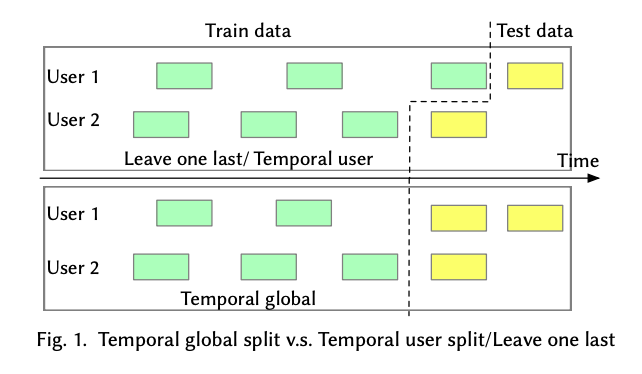

Суть метода *Temporal Global Split*, в том, что мы фиксируем определенный timestamp после которого все рейтинги отправляются уже в тестовую выборку. Так, мы избежим утечки данных, а именно не будем знать наперед ни рейтинги пользователя, ни рейтинги фильма, как и в реальном мире рекомендаций. 

Я также думала использовать *Temporal User* метод, в котором для каждого пользователя отдельно выберается timestamp для разделения его рейтингов в заранее заданном соотношении, но решила остановиться на *Temporal Global*, чтобы все же воссоздать ситуацию максимально приближенную к реальному построению рекомендательной системы, где мы знаем только данные до одного фиксированного момента времени для всех пользователей. 

Однако *Temporal Global* метод привел к потере значимого количества данных. Например, при выбранных мной параметрах разбиения датасета в тренировочный попало 67% рейтингов, а в валидационный и тестовый вместе не оставшиеся 33%, а всего 3%, так как при заданной конфигурации модели мы не сможем получить вектор пользователя, которого не было в обучающей выборке.

# Модель

Я решила взять за основу *Two Tower* подход. Один блок модели будет отвечать за эмбеддинг пользователя, второй -- за эмбеддинг фильма. Задача, которая будет использована для обучения эмбеддингов -- регрессинное предсказание рейтинга для пары пользователь-фильм путем минимизации ошибки MSE. Рейтинги переводятся во множество $\{0, 1\}$, где положительной оценкой считается рейтинг $>3,5$.

Подход к созданию эмбеддингов позаимствован из моделей NLP, то есть создается обучаемый эмбеддинговый слой размером `n_users x embedding_size`, откуда по индексу пользователя/фильма достается соответствующий вектор. Далее эти векторы по отдельности проходят через соответствующие им слои `nn.Linear` с нелинейностями между в виде функции `nn.ReLU`, после чего мы получаем на выходе нужный эмбеддинг.

Для построения эмбеддингов фильмов также использовались метаданные по тому же принципу: отдельные обучаемые `nn.Embedding` слои, откуда по индексам тегов/жанров достаются соответствующие значения и конкатенируются с эмбеддингом для `item_id`.

Минусы такого подхода следующие:
- огромный размер входного слоя (много пользователей/фильмов)
- невозможность создать эмбеддинг нового пользователя/фильма без обучения модели заново (для фильмов можно было бы брать какой-то дополнительный эмбеддинг, означающий отсутствующий в данных объект, так как помимо эмбеддинга по индексу у фильмов также присутствуют векторы для жанра и тегов)


Однако в итоге подход оказался несостоятельным по другой причие: так как эмбеддинги пользователей и фильмов находятся в разных векторных пространствах и искать между ними схожесть, на мой взгляд, задача некорректная. Для расчета метрики (далее) в качестве эмбеддинга пользователя будет использоваться не выход первой части модели, а усредненные эмбеддинги в прошлом высоко оцененных пользователем фильмов, так как в этом случае векторы пользователя и фильма будут уже находиться в общем векторном пространстве.

*Идея по улучшению этого подхода:*
- можно было бы изначально обучать эмбеддинг пользователя на основе высоко оцененных фильмов, как в статье eBay (https://arxiv.org/pdf/2102.06156.pdf)

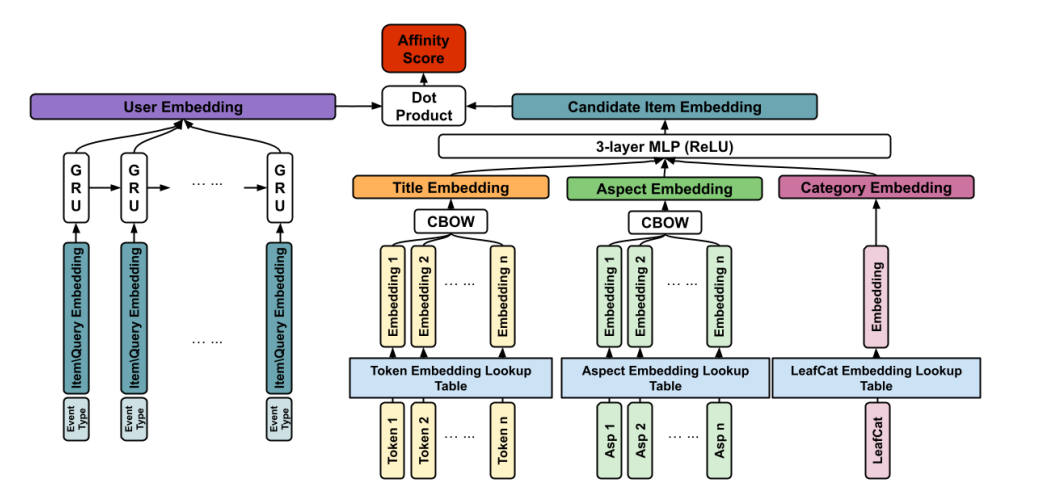

Тут тоже есть свои сложности: в статье в качестве истории пользователя использовались предыдущие интеракции с объектами, а данные для обучения эмбеддингов объектов целенаправленно собирались в течение дополнительных 30-ти дней. 

В случае нашей задачи можно было бы сделать разделение внутри тренировочной выборки на прошлые/настоящие взаимодействия, но как уже показало разделение на train/test выше, это приводит к большим потерям в данных.

# Обучение

Для удобства и читаемости ноутбука классы датасета и модели были вынесены в файлы `src.data.utils` и `src.model`.

In [ ]:
from src.data.utils import RatingsDataset
from src.model import MovieClassifier

%load_ext autoreload
%autoreload 2

In [10]:
DATA_ROOT = 'data_output'
train = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv'))
val = pd.read_csv(os.path.join(DATA_ROOT, 'val.csv'))

with open(os.path.join(DATA_ROOT, 'train_genres.pkl'), 'rb') as file:
    genres = pickle.load(file)

with open(os.path.join(DATA_ROOT, 'train_tags.pkl'), 'rb') as file:
    tags = pickle.load(file)

with open(os.path.join(DATA_ROOT, 'genres_to_ids.pkl'), 'rb') as file:
    genres_to_ids = pickle.load(file)

with open(os.path.join(DATA_ROOT, 'idx_to_uid.pkl'), 'rb') as file:
    idx_to_uid = pickle.load(file)

with open(os.path.join(DATA_ROOT, 'idx_to_iid.pkl'), 'rb') as file:
    idx_to_iid = pickle.load(file)
    
with open(os.path.join(DATA_ROOT, 'idx_to_tid.pkl'), 'rb') as file:
    idx_to_tid = pickle.load(file)

In [13]:
train_ds = RatingsDataset(train,
                 genres, 
                 tags, 
                 genres_to_ids,
                 idx_to_uid,
                 idx_to_iid,
                 idx_to_tid,
                 rating_cutoff=3.5)

val_ds = RatingsDataset(val,
                 genres, 
                 tags, 
                 genres_to_ids,
                 idx_to_uid,
                 idx_to_iid,
                 idx_to_tid,
                 rating_cutoff=3.5)

В этом месте тоже проблема выбранного подхода: так как количество жанров и тегов у фильмов различается, чтобы собирать их в батчи необходимо было приводить количества к одному, отсюда появляется паддинг. 

Эмбеддинги жанров и тегов внутри модели усредняются, поэтому нужно добавить код для игнорирования паддингового эмбеддинга, но к дедлайну рабочую версию сделать не получилось :(

In [14]:
TAG_PAD_TOKEN_ID = train_ds.tag_count
GENRE_PAD_TOKEN_ID = train_ds.genre_count
model = MovieClassifier(train_ds.user_count,
                        train_ds.item_count,
                        train_ds.genre_count + 1,
                        train_ds.tag_count + 1,
                        user_id_embed_dim=256, 
                        hidden_dim_users=1024,
                        item_id_embed_dim=128,
                        genres_embed_dim=64, 
                        tags_embed_dim=64,
                        hidden_dim_items=1024
                       ).to('cuda')

In [ ]:
def collate_fn(batch):
    max_tag, max_genre = 0, 0
    for item in batch:
        if len(item[2]) > max_genre:
            max_genre = len(item[2])
        if len(item[3]) > max_tag:
            max_tag = len(item[3])
    users = torch.zeros((len(batch), 1), dtype=torch.long)
    items = torch.zeros((len(batch), 1), dtype=torch.long)
    ratings = torch.zeros((len(batch)), dtype=torch.float32)
    tags = torch.full((len(batch), max_tag), TAG_PAD_TOKEN_ID, dtype=torch.long)
    genres = torch.full((len(batch), max_genre), GENRE_PAD_TOKEN_ID, dtype=torch.long)
    for i, item in enumerate(batch):
        users[i, :] = item[0].item()
        items[i, :] = item[1].item()
        ratings[i] = item[-1].item()
        tags[i, :len(item[3])] = item[3].clone()
        genres[i, :len(item[2])] = item[2].clone()
    return users, items, genres, tags, ratings
                      
        

train_dl = DataLoader(train_ds, batch_size = 512, collate_fn=collate_fn, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 512, collate_fn=collate_fn, shuffle=True)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
cuda = torch.device('cuda')
epochs = 2

losses, tr_losses, val_losses, ts = [], [], [], []
print_modulus = 1000
timestep = 0
min_val_loss = float('inf')

optimizer.zero_grad()
for epoch in range(epochs):
    print(f"EPOCH {epoch + 1}")
    # training
    model.train()
    for i, batch in enumerate(tqdm(train_dl)):
        user_id, item_id, gen, tag, rating, = batch
        pred = model(user_id.to(cuda), 
                     item_id.to(cuda), 
                     gen.to(cuda),
                     tag.to(cuda))
        pred = pred.squeeze(-1)
        rating = rating.squeeze(-1)
        loss = loss_fn(pred, rating.to(cuda))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        
        if timestep == 0 and epoch == 0 or timestep % print_modulus == 0:
            print(f"EPOCH {epoch + 1} :: BATCH {i + 1} :: MEAN LOSS {np.mean(losses):.4f}")
            tr_losses.append(np.mean(losses))
            ts.append(timestep)

            # validation
            model.eval()
            losses = []
            with torch.no_grad():
                for i, batch in enumerate(tqdm(val_dl, 
                                            position=0, 
                                            leave=True)):
                    user_id, item_id, gen, tag, rating = batch
                    pred = model(user_id.to(cuda), 
                                item_id.to(cuda), 
                                gen.to(cuda),
                                tag.to(cuda))
                    rating = rating.squeeze(-1)
                    pred = pred.squeeze(-1)
                    loss = loss_fn(pred, rating.to(cuda))
                    losses.append(loss.item())
            val_losses.append(np.mean(losses))
            if val_losses[-1] < min_val_loss:
              min_val_loss = val_losses[-1]
              torch.save(model.state_dict(), 'weights_big_features.pt')

            plt.plot(ts, tr_losses, label='Training')
            plt.plot(ts, val_losses, label='Validation')
            plt.xlabel('Timestep')
            plt.ylabel('MSE Loss')
            plt.title('Losses')
            plt.xticks(ts)  
            plt.legend()
            plt.savefig(f'ts_{timestep}.png')
            plt.clf()

            losses = []
            
        timestep += 1

EPOCH 1


  0%|          | 0/36353 [00:00<?, ?it/s]

EPOCH 1 :: BATCH 1 :: MEAN LOSS 0.2492


  3%|▎         | 1000/36353 [02:50<59:38,  9.88it/s] 

EPOCH 1 :: BATCH 1001 :: MEAN LOSS 0.2226


  6%|▌         | 2000/36353 [05:35<51:01, 11.22it/s]

EPOCH 1 :: BATCH 2001 :: MEAN LOSS 0.2110


  8%|▊         | 2999/36353 [08:20<56:15,  9.88it/s]

EPOCH 1 :: BATCH 3001 :: MEAN LOSS 0.2053


 11%|█         | 3999/36353 [11:07<57:31,  9.37it/s]  

EPOCH 1 :: BATCH 4001 :: MEAN LOSS 0.2006


 14%|█▍        | 5000/36353 [13:52<49:59, 10.45it/s]

EPOCH 1 :: BATCH 5001 :: MEAN LOSS 0.1981


 17%|█▋        | 5999/36353 [16:40<48:08, 10.51it/s]

EPOCH 1 :: BATCH 6001 :: MEAN LOSS 0.1959


 19%|█▉        | 6999/36353 [19:31<45:40, 10.71it/s]

EPOCH 1 :: BATCH 7001 :: MEAN LOSS 0.1948


 22%|██▏       | 8000/36353 [22:16<42:46, 11.05it/s]

EPOCH 1 :: BATCH 8001 :: MEAN LOSS 0.1933


 25%|██▍       | 8999/36353 [25:02<41:12, 11.07it/s]

EPOCH 1 :: BATCH 9001 :: MEAN LOSS 0.1923


 28%|██▊       | 10000/36353 [27:51<1:02:07,  7.07it/s]

EPOCH 1 :: BATCH 10001 :: MEAN LOSS 0.1918


 30%|███       | 11000/36353 [30:42<42:21,  9.97it/s]

EPOCH 1 :: BATCH 11001 :: MEAN LOSS 0.1909


 33%|███▎      | 12000/36353 [33:30<57:20,  7.08it/s]

EPOCH 1 :: BATCH 12001 :: MEAN LOSS 0.1905


 36%|███▌      | 12999/36353 [36:20<36:42, 10.60it/s]

EPOCH 1 :: BATCH 13001 :: MEAN LOSS 0.1894


 39%|███▊      | 14000/36353 [39:15<37:06, 10.04it/s]

EPOCH 1 :: BATCH 14001 :: MEAN LOSS 0.1893


 41%|████▏     | 14999/36353 [42:03<34:29, 10.32it/s]

EPOCH 1 :: BATCH 15001 :: MEAN LOSS 0.1891


 44%|████▍     | 16000/36353 [45:01<34:49,  9.74it/s]

EPOCH 1 :: BATCH 16001 :: MEAN LOSS 0.1883


 47%|████▋     | 16999/36353 [47:54<30:24, 10.61it/s]

EPOCH 1 :: BATCH 17001 :: MEAN LOSS 0.1875


 50%|████▉     | 18000/36353 [50:46<41:40,  7.34it/s]

EPOCH 1 :: BATCH 18001 :: MEAN LOSS 0.1877


 52%|█████▏    | 18999/36353 [53:32<27:13, 10.62it/s]

EPOCH 1 :: BATCH 19001 :: MEAN LOSS 0.1869


 55%|█████▌    | 19999/36353 [56:16<27:00, 10.09it/s]

EPOCH 1 :: BATCH 20001 :: MEAN LOSS 0.1864


 58%|█████▊    | 21000/36353 [59:02<33:24,  7.66it/s]

EPOCH 1 :: BATCH 21001 :: MEAN LOSS 0.1863


 61%|██████    | 21999/36353 [1:01:46<21:06, 11.34it/s]

EPOCH 1 :: BATCH 22001 :: MEAN LOSS 0.1860


 63%|██████▎   | 22999/36353 [1:04:28<19:59, 11.13it/s]

EPOCH 1 :: BATCH 23001 :: MEAN LOSS 0.1855


 66%|██████▌   | 24000/36353 [1:07:17<19:56, 10.32it/s]

EPOCH 1 :: BATCH 24001 :: MEAN LOSS 0.1859


 69%|██████▉   | 24999/36353 [1:10:02<17:32, 10.79it/s]

EPOCH 1 :: BATCH 25001 :: MEAN LOSS 0.1851


 72%|███████▏  | 26000/36353 [1:12:47<15:37, 11.05it/s]

EPOCH 1 :: BATCH 26001 :: MEAN LOSS 0.1853


 74%|███████▍  | 27000/36353 [1:15:32<14:57, 10.42it/s]

EPOCH 1 :: BATCH 27001 :: MEAN LOSS 0.1850


 77%|███████▋  | 28000/36353 [1:18:21<13:34, 10.25it/s]

EPOCH 1 :: BATCH 28001 :: MEAN LOSS 0.1847


 80%|███████▉  | 29000/36353 [1:21:06<11:21, 10.79it/s]

EPOCH 1 :: BATCH 29001 :: MEAN LOSS 0.1845


 83%|████████▎ | 30000/36353 [1:23:50<09:56, 10.65it/s]

EPOCH 1 :: BATCH 30001 :: MEAN LOSS 0.1839


 85%|████████▌ | 31000/36353 [1:26:39<12:33,  7.10it/s]

EPOCH 1 :: BATCH 31001 :: MEAN LOSS 0.1839


 88%|████████▊ | 32000/36353 [1:29:27<06:36, 10.99it/s]

EPOCH 1 :: BATCH 32001 :: MEAN LOSS 0.1835


 91%|█████████ | 32999/36353 [1:32:08<05:04, 11.01it/s]

EPOCH 1 :: BATCH 33001 :: MEAN LOSS 0.1833


 94%|█████████▎| 33999/36353 [1:34:53<03:30, 11.20it/s]

EPOCH 1 :: BATCH 34001 :: MEAN LOSS 0.1835


 96%|█████████▋| 34999/36353 [1:37:38<02:16,  9.91it/s]

EPOCH 1 :: BATCH 35001 :: MEAN LOSS 0.1830


 99%|█████████▉| 36000/36353 [1:40:28<00:34, 10.09it/s]

EPOCH 1 :: BATCH 36001 :: MEAN LOSS 0.1830


100%|██████████| 36353/36353 [1:42:09<00:00,  5.93it/s]


<Figure size 640x480 with 0 Axes>

In [ ]:
# тут была вторая эпоха, теперь в ячейке выше сразу две!

EPOCH 2


  2%|▏         | 646/36353 [01:10<56:08, 10.60it/s]

EPOCH 2 :: BATCH 648 :: MEAN LOSS 0.1783


  5%|▍         | 1646/36353 [03:56<52:16, 11.07it/s]

EPOCH 2 :: BATCH 1648 :: MEAN LOSS 0.1789


  7%|▋         | 2646/36353 [06:42<53:52, 10.43it/s]

EPOCH 2 :: BATCH 2648 :: MEAN LOSS 0.1790


 10%|█         | 3647/36353 [09:38<53:51, 10.12it/s]

EPOCH 2 :: BATCH 3648 :: MEAN LOSS 0.1785


 13%|█▎        | 4647/36353 [12:25<1:17:27,  6.82it/s]

EPOCH 2 :: BATCH 4648 :: MEAN LOSS 0.1793


 16%|█▌        | 5647/36353 [15:10<50:19, 10.17it/s]

EPOCH 2 :: BATCH 5648 :: MEAN LOSS 0.1794


 18%|█▊        | 6646/36353 [17:59<45:45, 10.82it/s]

EPOCH 2 :: BATCH 6648 :: MEAN LOSS 0.1788


 21%|██        | 7647/36353 [20:41<43:26, 11.02it/s]

EPOCH 2 :: BATCH 7648 :: MEAN LOSS 0.1794


 24%|██▍       | 8646/36353 [23:24<43:24, 10.64it/s]

EPOCH 2 :: BATCH 8648 :: MEAN LOSS 0.1796


 27%|██▋       | 9647/36353 [26:05<44:32,  9.99it/s]

EPOCH 2 :: BATCH 9648 :: MEAN LOSS 0.1792


 29%|██▉       | 10647/36353 [28:48<40:01, 10.70it/s]

EPOCH 2 :: BATCH 10648 :: MEAN LOSS 0.1793


 32%|███▏      | 11646/36353 [31:28<37:46, 10.90it/s]

EPOCH 2 :: BATCH 11648 :: MEAN LOSS 0.1795


 35%|███▍      | 12647/36353 [34:09<37:10, 10.63it/s]

EPOCH 2 :: BATCH 12648 :: MEAN LOSS 0.1790


 38%|███▊      | 13646/36353 [36:48<37:48, 10.01it/s]

EPOCH 2 :: BATCH 13648 :: MEAN LOSS 0.1793


 40%|████      | 14647/36353 [39:34<34:42, 10.42it/s]

EPOCH 2 :: BATCH 14648 :: MEAN LOSS 0.1795


 43%|████▎     | 15647/36353 [42:16<40:16,  8.57it/s]

EPOCH 2 :: BATCH 15648 :: MEAN LOSS 0.1795


 46%|████▌     | 16646/36353 [44:58<29:35, 11.10it/s]

EPOCH 2 :: BATCH 16648 :: MEAN LOSS 0.1789


 49%|████▊     | 17647/36353 [47:40<29:20, 10.63it/s]

EPOCH 2 :: BATCH 17648 :: MEAN LOSS 0.1791


 51%|█████▏    | 18647/36353 [50:27<26:05, 11.31it/s]

EPOCH 2 :: BATCH 18648 :: MEAN LOSS 0.1787


 54%|█████▍    | 19647/36353 [53:09<25:37, 10.87it/s]

EPOCH 2 :: BATCH 19648 :: MEAN LOSS 0.1790


 57%|█████▋    | 20647/36353 [55:54<25:22, 10.31it/s]

EPOCH 2 :: BATCH 20648 :: MEAN LOSS 0.1788


 60%|█████▉    | 21646/36353 [58:45<23:31, 10.42it/s]

EPOCH 2 :: BATCH 21648 :: MEAN LOSS 0.1792


 62%|██████▏   | 22646/36353 [1:01:35<23:09,  9.86it/s]

EPOCH 2 :: BATCH 22648 :: MEAN LOSS 0.1791


 65%|██████▌   | 23647/36353 [1:04:24<20:08, 10.52it/s]

EPOCH 2 :: BATCH 23648 :: MEAN LOSS 0.1789


 68%|██████▊   | 24647/36353 [1:07:15<20:22,  9.57it/s]

EPOCH 2 :: BATCH 24648 :: MEAN LOSS 0.1790


 71%|███████   | 25646/36353 [1:10:10<17:39, 10.10it/s]

EPOCH 2 :: BATCH 25648 :: MEAN LOSS 0.1790


 73%|███████▎  | 26647/36353 [1:13:09<17:18,  9.35it/s]

EPOCH 2 :: BATCH 26648 :: MEAN LOSS 0.1793


 76%|███████▌  | 27647/36353 [1:16:00<14:16, 10.17it/s]

EPOCH 2 :: BATCH 27648 :: MEAN LOSS 0.1786


 79%|███████▉  | 28647/36353 [1:18:55<14:22,  8.94it/s]

EPOCH 2 :: BATCH 28648 :: MEAN LOSS 0.1789


 82%|████████▏ | 29646/36353 [1:21:44<11:55,  9.37it/s]

EPOCH 2 :: BATCH 29648 :: MEAN LOSS 0.1792


 84%|████████▍ | 30647/36353 [1:24:29<08:29, 11.19it/s]

EPOCH 2 :: BATCH 30648 :: MEAN LOSS 0.1785


 87%|████████▋ | 31647/36353 [1:27:17<11:02,  7.10it/s]

EPOCH 2 :: BATCH 31648 :: MEAN LOSS 0.1785


 90%|████████▉ | 32646/36353 [1:30:05<05:47, 10.66it/s]

EPOCH 2 :: BATCH 32648 :: MEAN LOSS 0.1785


 93%|█████████▎| 33647/36353 [1:32:51<04:05, 11.01it/s]

EPOCH 2 :: BATCH 33648 :: MEAN LOSS 0.1786


 95%|█████████▌| 34647/36353 [1:35:36<02:31, 11.24it/s]

EPOCH 2 :: BATCH 34648 :: MEAN LOSS 0.1782


 98%|█████████▊| 35646/36353 [1:38:23<01:35,  7.44it/s]

EPOCH 2 :: BATCH 35648 :: MEAN LOSS 0.1782


100%|██████████| 36353/36353 [1:40:42<00:00,  6.02it/s]


<Figure size 640x480 with 0 Axes>

На графике показаны значения функции потерь на обучающей и валидационной выборках для 720_000 шагов обучения (две эпохи). 

Времени до дедлайна не хватило, чтобы обучить подольше, но уже на второй эпохе лосс оставался примерно на одном уровне.

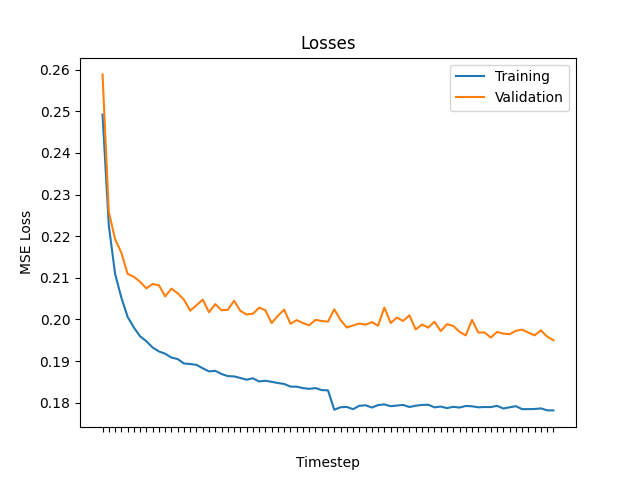

# Метрика

В качестве метрики для рекомендаций я выбрала `precision@k`, так как задача рекомендательной системы -- максимизировать количество релевантных для пользователя фильмов и сделать это в самом начале списка рекомендаций. Будем смотреть на первые 25 элементов этого списка, отсортированных в соответствии с расстояниями между векторами, так как в тестовом множестве оценок у пользователей не очень много и если смотреть на точность по первым, скажем, пяти рекомендациям, она будет совсем уж плачевная.

<Axes: >

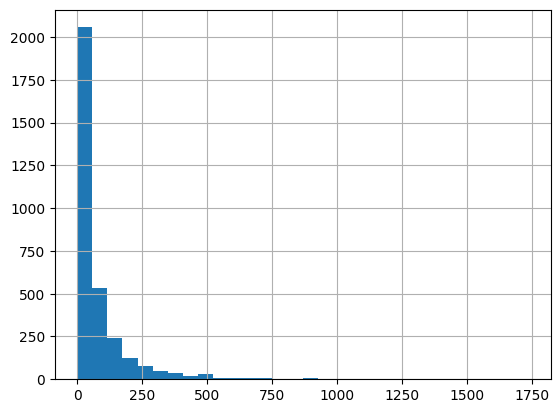

In [15]:
test = pd.read_csv('data_output/test.csv')
test.groupby('userId')['rating'].count().hist(bins=30)

In [70]:
def precision_at_k(recommendations, relevant_items, k=5):
  return len(np.intersect1d(recommendations[:k], relevant_items)) / k

Следующая функция громоздная и неоптимальная по времени, оптимизировать ее до дедлайна я уже не успею :(

In [83]:
def recommend(user, ds, model, k=5, device='cuda'):
    with torch.no_grad():
        user_id = ds.uid_to_idx[user]
        # user_emb = model.user_emb(torch.tensor([user_id], dtype=torch.long).unsqueeze(0).to(device))
        
        # user embedding is the average of items they rated over 4.
        highly_rated = ds.ratings[ds.ratings[Columns.user_id] == user]
        highly_rated = highly_rated[highly_rated[Columns.rating] > 3.5][Columns.item_id].tolist()
        item_embs = torch.zeros((len(highly_rated), 256), dtype=torch.float32)
        for i, real_item_id in enumerate(highly_rated):
            item_id = ds.iid_to_idx[real_item_id]
            genres, tags = ds.genres[item_id], ds.tags[item_id]
            if not len(genres):
                genres.append(GENRE_PAD_TOKEN_ID)
            if not len(tags):
                tags.append(TAG_PAD_TOKEN_ID)
            item_emb = model.item_emb(torch.tensor([item_id], dtype=torch.long).unsqueeze(0).to(device), 
                                    torch.tensor(genres, dtype=torch.long).unsqueeze(0).to(device), 
                                    torch.tensor(tags, dtype=torch.long).unsqueeze(0).to(device))
            item_embs[i, :] = item_emb.clone()
        user_emb = item_embs.mean(dim=0).unsqueeze(0)
            
        watched = set(ds.ratings[ds.ratings[Columns.user_id] == user][Columns.item_id].tolist())
        recs = []
        for item_id in range(ds.item_count):
            real_item_id = ds.idx_to_iid[item_id]
            if real_item_id in watched:
                continue
            genres, tags = ds.genres[item_id], ds.tags[item_id]
            if not len(genres):
                genres.append(GENRE_PAD_TOKEN_ID)
            if not len(tags):
                tags.append(TAG_PAD_TOKEN_ID)
            item_emb = model.item_emb(torch.tensor([item_id], dtype=torch.long).unsqueeze(0).to(device), 
                                    torch.tensor(genres, dtype=torch.long).unsqueeze(0).to(device), 
                                    torch.tensor(tags, dtype=torch.long).unsqueeze(0).to(device))
            
            sim = cosine_similarity(user_emb.cpu().numpy(), 
                                    item_emb.cpu().numpy())
            
            recs.append((real_item_id, sim.item()))
    return sorted(recs, key=lambda x: x[1], reverse=True)[:k]

Посмотрим метрику для двухсот случайных пользователей, так как считается эта функция очень долго:

In [92]:
k = 25
pr = 0.
n_users = 200
for user in tqdm(np.random.choice(test[Columns.user_id].unique(), size=n_users)):
    recs = recommend(user, train_ds, model, k=k)
    recs = [rec[0] for rec in recs]
    relevant_items = test[test[Columns.user_id] == user]
    relevant_items = relevant_items[relevant_items[Columns.rating] > 3.5][Columns.item_id].to_numpy()
    pr += precision_at_k(recs, relevant_items, k=k)


100%|██████████| 200/200 [49:48<00:00, 14.94s/it]

PRECISION@25 for 200: 0.00600


In [93]:
print(f"PRECISION@25 for {n_users}: {pr / n_users:.5f}")

PRECISION@25 for 200: 0.00600


**Итог:** релевантных рекомендаций в первых 25-ти для двухсот пользователей оказалось всего 0.6% процента. Модель работает очень плохо, поэтому вот некоторые идеи для исправления этого:

- убрать паддинговые эмбеддинги из усреднения (неясно, что в них обучится и они могут искажать информацию о тегах и жанрах фильмов, особенно в неудачных батчах, где паддинга может быть много)
- дообучить сеть, добавив график для learning rate, так как вполне возможно, что она попала в локальный минимум, плюс двух эпох может быть мало
- попробовать другие размерности первого слоя эмбеддингов и линейных слоев
- добавить в процесс формирования эмбеддинга пользователя при обучении информацию о фильмах, оцененных им до времени формирования тренировочной выборки (разделить train на две части по timestamp)
- формировать входные эмбеддинги с помощью матричного разложения (например, ALS) и прогонять уже их через сеть, добавив также эмбеддинги для метадаты по фильмам
- использовать также названия и год выпуска фильмов 